In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy.optimize import minimize

### 16.3.2 Bonds in Practice: Comparison of Risky & Risk-Free Bond Duration

In this coding example, we implement a pricing function for a bond with and without embedded default risk, and then calculate corresponding durations. We assume constant interest rates, as well as a constant hazard rate, $\lambda$ for the risky bond, however, the reader is encouraged to extend this to a more realistic assumptions of time-varying interest and default rates.

In [ ]:
def price_bond(lamb, pay_times, rf, c, recovery):
    '''
    lamb: hazard rate
    pay_times: payment times in years (1 to maturity)
    rf: risk-free rate
    c: coupon payment
    recovery: recovery rate
    '''

    rf_bond = [np.exp(-x*rf) for x in pay_times]
    surv_prob = [np.exp(-lamb*x) for x in pay_times]        # (16.4)
    default_prob = [1-x for x in surv_prob]

    default_B = 0
    nondefault_B = 0

    for i in range(len(pay_times)):                         # (16.7)
        default_B += c*rf_bond[i] * surv_prob[i] + recovery*lamb*rf_bond[i]*surv_prob[i]
        nondefault_B += c*rf_bond[i]

    default_B += rf_bond[-1]*surv_prob[-1]
    nondefault_B += rf_bond[-1]

    return default_B, nondefault_B

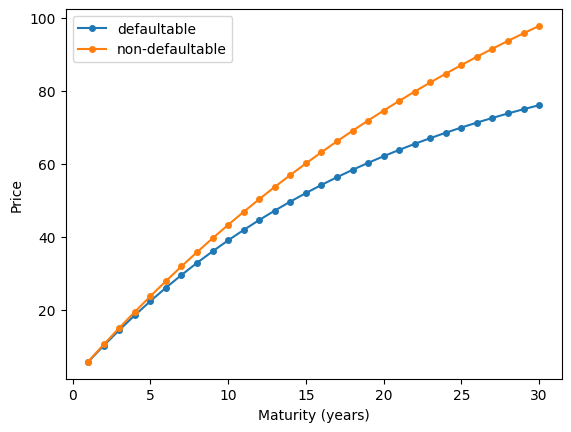

In [ ]:
# example
lamb = 0.02
rf = 0.03
c = 5
recovery = 0.4
N = 30

default_price_list = []
nondefault_price_list = []

for n in range(1, N+1):
    pay_times = list(range(1, n+1))
    default_price, nondefault_price = price_bond(lamb, pay_times, rf, c, recovery)
    default_price_list.append(default_price)
    nondefault_price_list.append(nondefault_price)

df_price = pd.DataFrame({'defaultable': default_price_list,
                         'non-defaultable': nondefault_price_list},
                        index=range(1, N+1))

ax = df_price.plot(marker='o', markersize=4)
ax.set_ylabel('Price')
ax.set_xlabel('Maturity (years)')
plt.plot();

In [ ]:
def calculate_duration(lamb, rf, c, recovery, maturity):
    '''
    lamb: hazard rate
    rf: risk-free rate
    c: coupon payment
    recovery: recovery rate
    maturity: in year
    '''

    pay_times = list(range(1, maturity + 1))
    rf_bond = [np.exp(-x * rf) for x in pay_times]
    surv_prob = [np.exp(-lamb * x) for x in pay_times]

    bond_prices = price_bond(lamb, pay_times, rf, c, recovery)

    durations_default = sum(t * c * rf_bond[i] * surv_prob[i] / bond_prices[0] for i, t in enumerate(pay_times))
    durations_nondefault = sum(t * c * rf_bond[i] / bond_prices[1] for i, t in enumerate(pay_times))

    durations_default += maturity * rf_bond[-1] * surv_prob[-1] / bond_prices[0]
    durations_nondefault += maturity * rf_bond[-1] / bond_prices[1]

    return durations_default/100, durations_nondefault/100

Sensitivities can be calculated either in absolute or relative (as a percentage of the price) terms. The readers are encouraged to explore the differences.

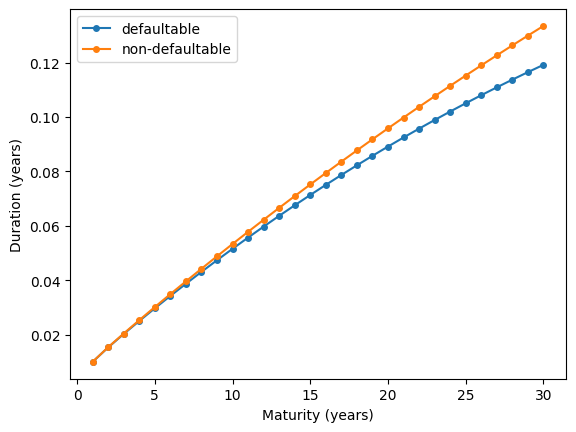

In [ ]:
# example
maturities = list(range(1, N+1))
durations = [calculate_duration(lamb, rf, c, recovery, m) for m in maturities]
df_duration = pd.DataFrame(durations, columns=['defaultable', 'non-defaultable'], index=range(1, N+1))

plt.plot(maturities, df_duration['defaultable'], marker='o', markersize=4, label='defaultable')
plt.plot(maturities, df_duration['non-defaultable'], marker='o', markersize=4, label='non-defaultable')
plt.xlabel('Maturity (years)')
plt.ylabel('Duration (years)')
plt.legend()
plt.show()

Apart from the analytical approach, we can also calculate bond durations from the numerical perspective:

In [ ]:
# numerical approach
def duration_conv(lamb, rf, c, recovery, maturity, delta=0.05):
    '''
    lamb: hazard rate
    rf: risk-free rate
    c: coupon payment
    recovery: recovery rate
    maturity: in year
    delta: small change in risk-free rate
    '''

    h = delta*rf

    pay_times = list(range(1, maturity+1))

    df_Bond_dur = []
    nondf_Bond_dur = []
    df_Bond_conv = []
    nondf_Bond_conv = []


    for t in pay_times:

        result = price_bond(lamb, range(1,t+1), rf, c, recovery)
        result_hi = price_bond(lamb, range(1,t+1), rf+h, c, recovery)
        result_lo = price_bond(lamb, range(1+t+1), rf-h, c, recovery)

        duration_df = -(result_hi[0] - result[0])/(result[0]*h)
        convexity_df = (result_hi[0] - 2*result[0] + result_lo[0])/(h**2)

        duration_nondf = -(result_hi[1] - result[1])/(result[1]*h)
        convexity_nondf = (result_hi[1] - 2*result[1] + result_lo[1])/(h**2)

        df_Bond_dur.append(duration_df)
        nondf_Bond_dur.append(duration_nondf)
        df_Bond_conv.append(convexity_df/result[0])
        nondf_Bond_conv.append(convexity_nondf/result[1])

    plt.plot(pay_times, df_Bond_dur, label = 'defaultable')
    plt.plot(pay_times, nondf_Bond_dur, label = 'non-defaultable')
    plt.ylabel("Duration (years)")
    plt.xlabel("Maturity (years)")
    plt.legend()

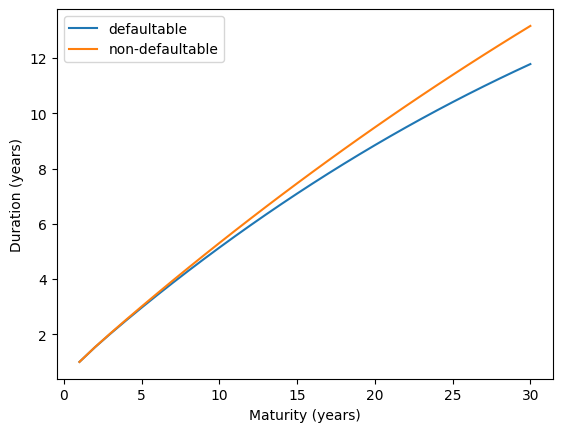

In [ ]:
# same example
duration_conv(lamb, rf, c, recovery, maturity=30)

### 16.6.3 Alternate Approach: Optimization

In addition to the bootstrapping procedure for a CDS curve introduced in 16.6.2, we can also formulate the problem as an optimization task and solve it using `SciPy`'s built in [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function:

In [ ]:
def getSurvProbAtT(T, cdsTenors, cdsLambdas, recov):
    '''
    T: time of calculation
    cdsTenors: CDS tenors (maturity times)
    cdsLambdas: hazard rates for each tenor
    recov: recovery rate
    '''

    survProb = 1.0
    prevT = 0.0

    for tenor_ii, lambda_ii in zip(cdsTenors, cdsLambdas):
        if (T > prevT):
            tau = min(tenor_ii, T) - prevT
            survProb *= np.exp(-tau * lambda_ii)
        prevT = tenor_ii

    return survProb


def pvCDS(cdsTenors, cdsLambdas, cdsSpreads, cdsMat, coupon_frequency, rf, recov):
    '''
    cdsTenors: CDS tenors (maturity times)
    cdsLambdas: hazard rates for each tenor
    cdsSpreads: CDS spreads
    cdsMat: maturity time
    coupon_frequency: frequency of coupon payments
    rf: risk-free rate
    recov: recovery rate
    '''

    total_payments = int(coupon_frequency * cdsMat)
    pv_def_leg = 0.0
    pv_no_def_leg = 0.0

    for payment in range(1, total_payments+1):

        payment_time = payment/coupon_frequency
        pv_no_def_leg += cdsSpreads * np.exp(-rf * payment_time) * getSurvProbAtT(payment_time, cdsTenors, cdsLambdas, recov) / coupon_frequency   # (16.12)

        lambda_ord = np.where(cdsTenors == min(cdsTenors[cdsTenors >= payment_time]))[0][0]
        lambda_curr = cdsLambdas[lambda_ord]

        pv_def_leg += (1 - recov) * np.exp(-rf * payment_time) * getSurvProbAtT(payment_time, cdsTenors, cdsLambdas, recov) * lambda_curr          # (16.16)

    return pv_def_leg, pv_no_def_leg


def cdsPricingErrorSquared(cdsLambdas, cdsTenors, cdsSpreads, coupon_frequency, rf, recov):
    '''
    cdsTenors: CDS tenors (maturity times)
    cdsLambdas: hazard rates for each tenor
    cdsSpreads: CDS spreads
    coupon_frequency: the frequency of coupon payments
    rf: risk-free rate
    recov: recovery rate
    '''

    sse = 0.0  # sum of squared errors

    for tenor_ii, spread_ii in zip(cdsTenors, cdsSpreads):
        pv_def_leg_ii, pv_no_def_leg_ii = pvCDS(cdsTenors, cdsLambdas, spread_ii, tenor_ii, coupon_frequency, rf, recov)
        pv_cds_ii = (pv_def_leg_ii - pv_no_def_leg_ii)
        sse += pv_cds_ii**2

    return sse

In [ ]:
# example
cdsSpreads = np.asarray([120, 135, 150, 160, 175]) / 10000.0
cdsTenors = np.asarray([1, 3, 5, 7, 10])
cdsLambdas = [0.05, 0.05, 0.05, 0.05, 0.05]   # initial guess
coupon_frequency = 2
rf = 0.005
recov = 0.4

res = minimize(cdsPricingErrorSquared,
               x0 = cdsLambdas,
               bounds = ((0.0, None),(0.0, None), (0.0, None), (0.0, None), (0.0, None)),
         	     args = (cdsTenors, cdsSpreads, coupon_frequency, rf, recov),
         	     tol = 1e-12,
         	     method = 'SLSQP',
         	     options={'maxiter': 2500, 'ftol': 1e-14})

print(res.x)

[0.01000002 0.01189069 0.01446194 0.01556267 0.01781991]


### 16.7.4 Credit Indices in Practice: Extracting IG & HY Index Hazard Rates

In this coding exmaple, we show how to extract the most recent hazard rates for the current on-the-run High Yield (HY) and Investment Grade (IG) credit indices using the optmization approach detailed in 16.6.3:

| Tenor | IG Spread (BPS) | HY Spread (BPS) |
| --- | --- | --- |
| 3y | $30.067$ | $247.691$ |
| 5y | $49.2$ | $308.296$ |
| 7y | $70.745$ | $330.988$ |
| 10y | $91.702$ | - |

In [ ]:
# set parameters
cdsSpreads_ig = np.array([30.067, 49.2, 70.745, 91.702]) / 1e4
cdsSpreads_hy = np.array([247.691, 308.296, 330.988]) / 1e4
cdsTenors = np.array([3, 5, 7, 10])
coupon_frequency = 2
rf = 0.043
recov_ig = 0.4
recov_hy = 0.3

# initial guess
cdsLambdas_ig = [0.05, 0.05, 0.05, 0.05]
cdsLambdas_hy = [0.05, 0.05, 0.05]

In [ ]:
# optimization
res_ig = minimize(cdsPricingErrorSquared,
                  x0 = cdsLambdas_ig,
                  bounds = ((0.0, None),(0.0, None), (0.0, None), (0.0, None)),
                  args = (cdsTenors, cdsSpreads_ig, coupon_frequency, rf, recov_ig),
                  tol = 1e-12,
                  method = 'SLSQP',
                  options={'maxiter': 2500, 'ftol': 1e-14})

res_hy = minimize(cdsPricingErrorSquared,
                  x0 = cdsLambdas_hy,
                  bounds = ((0.0, None),(0.0, None), (0.0, None)),
                  args = (cdsTenors[:3], cdsSpreads_hy, coupon_frequency, rf, recov_hy),
                  tol = 1e-12,
                  method = 'SLSQP',
                  options={'maxiter': 2500, 'ftol': 1e-14})

In [ ]:
df_ig = pd.DataFrame({'IG': res_ig.x}, index=cdsTenors)
df_ig

,IG
3,0.002506
5,0.006795
7,0.011261
10,0.012973


In [ ]:
df_hy = pd.DataFrame({'HY': res_hy.x}, index=cdsTenors[:3])
df_hy

,HY
3,0.017692
5,0.029697
7,0.028835


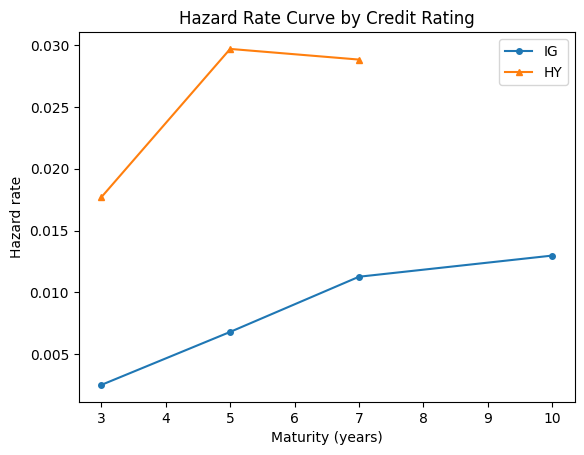

In [ ]:
plt.plot(cdsTenors, df_ig, marker='o', markersize=4, label='IG')
plt.plot(cdsTenors[:3], df_hy, marker='^', markersize=4, label='HY')
plt.xlabel('Maturity (years)')
plt.ylabel('Hazard rate')
plt.legend()
plt.title('Hazard Rate Curve by Credit Rating')
plt.show()

### 16.9.1 Options on CDS

In this coding example we show how Black's model can be applied to the case of a knock-out swaption on a single name credit default swap:

In [ ]:
def payer_swaption(F, K, sigma, t, swapT, rf, const_lamb, coupon_frequency):
    '''
    F: forward swap rate
    K: strike rate
    sigma: forward swap rate volatility
    t: time to expiry of the option
    swapT: maturity of the swap
    rf: risk-free rate
    const_lamb: constant hazard rate
    coupon_frequency: frequency of the coupon payments
    '''

    d1 = (np.log(F/K) + 0.5*sigma**2*t)/(sigma * np.sqrt(t))
    d2 = (np.log(F/K) - 0.5*sigma**2*t)/(sigma * np.sqrt(t))

    ra = 0.0
    matT = swapT + t
    total_payments = int(coupon_frequency * swapT)
    for payment in range(1, total_payments+1):
        payment_time = payment/coupon_frequency
        ra += np.exp(-rf * payment_time) * np.exp(-const_lamb * payment_time)

    swn_px = ra * (F * norm.cdf(d1) - K * norm.cdf(d2))             # (16.34)
    return swn_px

In [ ]:
# example
F = 500.0/10000.0
K = 500.0 / 10000.0
sigma = 0.2
t = 1.0
swapT = 5.0
rf = 0.01
const_lamb = 0.025
coupon_frequency = 2

print(f'The price of the payer swaption is {payer_swaption(F, K, sigma, t, swapT, rf, const_lamb, coupon_frequency):.4f}')

The price of the payer swaption is 0.0362


### 16.10.6 CDO Correlation in Practice: Impact of Correlation on Tranche Valuation

In this coding sample we leverage the formulas presented in the chapter to detail how an index loss distribution can be modeled in Python under the assumption that all credits are homogeneous:

In [ ]:
def index_loss_distr(N, M, rho, spread, recov, tau):
    '''
    N: number of credit instruments in the portfolio
    M: discretization grids
    rho: correlation between the default probabilities of individual credit instruments in the portfolio
    spread: credit spread
    recov: recovery rate
    tau: time to maturity
    '''

    implied_lambda = spread / (1 - recov)
    surv_prob = np.exp(-implied_lambda * tau)
    def_prob = 1 - surv_prob
    C = norm.ppf(def_prob)

    fLs = np.zeros(N+1)  # initialization

    for ii in range(M+1):
        Zi = -5.0 + ii * (10 / M)
        phiZ = norm.pdf(Zi)
        dz = 10 / M

        for n in range(N+1):
            innerNumer = C - rho*Zi
            innerDenom = np.sqrt(1 - rho**2)
            innerTerm = innerNumer / innerDenom

            pLCondZ = (1 - recov) * norm.cdf(innerTerm)                                                                   # (16.45)
            fLCondZ = (math.factorial(N) / (math.factorial(n) * math.factorial(N-n))) *pLCondZ**n * (1-pLCondZ)**(N-n)    # (16.46)
            fLs[n] += fLCondZ * phiZ * dz

    return fLs

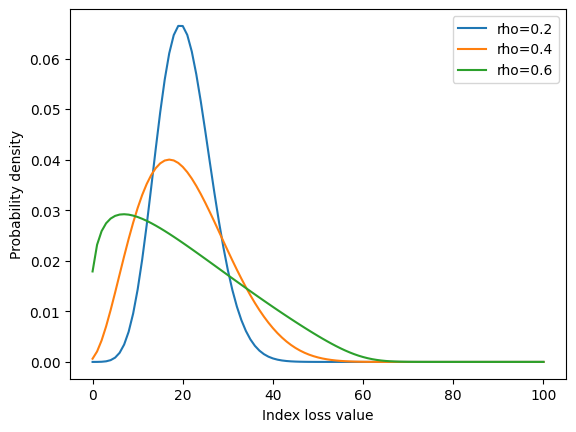

In [ ]:
# example
spread = 500.0 / 10000.0
recov = 0.4
tau = 5.0
N = 100
M = 200
rho_list = [0.2, 0.4, 0.6]

for rho in rho_list:
    fLs = index_loss_distr(N, M, rho, spread, recov, tau)
    plt.plot(fLs, label=f'rho={rho}')

plt.xlabel('Index loss value')
plt.ylabel('Probability density')
plt.legend()
plt.show()

### 16.11.1 Merton's Model

In the following coding example, we show how to compute a firm's distance to default (DD) and probability of default under the Merton's model with a known default barrier, that is, known asset value and asset volatility, and constant liability:

In [ ]:
def merton_model(A, L, sigma, t, r):
    '''
    A: asset value
    L: liability value
    sigma: asset volatility
    t: time to maturity of the debt
    r: risk-free rate
    '''

    DD = (np.log(A/L) + (r - 0.5*sigma**2) * t) / (sigma * np.sqrt(t))    # (16.52)
    Q = 1 - norm.cdf(DD)                                                  # (16.53)

    return DD, Q

In [ ]:
# example
A = 100.0
L = 90.0
sigma = 0.2
t = 5.0
r = 0.03

DD, Q = merton_model(A, L, sigma, t, r)
print(f"Distance to default (DD) from Merton's model: {DD:.4f}")
print(f"Default probability from Merton's model: {Q:.4f}")

Distance to default (DD) from Merton's model: 0.3474
Default probability from Merton's model: 0.3641


In more complex scenarios where the default barrier is uncertain, DD and default probability can be computed from the inferred asset value and asset volatility through optimization:

In [ ]:
def solveForAssetValueAndVol(params, L, E, sigmaEq, t, r, eps=1e-12):

    A, sigmaAssets = params

    # ensure numerical stability
    safe_den = np.maximum(sigmaAssets * np.sqrt(np.maximum(t, eps)), eps)

    d1 = (np.log(A/L) + (r + 0.5*sigmaAssets**2) * t) / safe_den
    d2 = d1 - sigmaAssets*np.sqrt(t)                                     # (16.50)
    EHat = (A * norm.cdf(d1) - L * np.exp(-r*t) * norm.cdf(d2))          # (16.49)

    # penalize invalid EHat
    if EHat <= 0:
        return 1e12

    else:
        sigmaEqHat = sigmaAssets * norm.cdf(d1) * A / EHat               # (16.51)

        eError = (EHat - E)**2
        volError = (sigmaEqHat - sigmaEq)**2

        return eError + volError

In [ ]:
# example
L = 90.0
E = 10.0
sigmaEq = 0.5
t = 5.0
r = 0.03

x0 = np.array([L + E, 0.02])
bounds = [(1e-8, None), (1e-8, 5.0)]

res = minimize(solveForAssetValueAndVol,
               x0 = x0,
               bounds = bounds,
         	     args = (L, E, sigmaEq, t, r),
         	     tol = 1e-10,
         	     method = 'SLSQP',
         	     options={'maxiter': 400, 'ftol': 1e-14})['x']

print(f'Inferred asset value: {res[0]:.4f}')
print(f'Inferred asset volatility: {res[1]:.4f}')

DD, Q = merton_model(res[0], L, res[1], t, r)
print(f"Distance to default (DD) from Merton's model: {DD:.4f}")
print(f"Default probability from Merton's model: {Q:.4f}")

Inferred asset value: 84.1484
Inferred asset volatility: 0.0846
Distance to default (DD) from Merton's model: 0.3433
Default probability from Merton's model: 0.3657
